<a href="https://colab.research.google.com/github/lbaierreinio/xgboost-customer-churn/blob/main/xg_boost_customer_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XGBoost for Customer Churn

Use XGBoost to build a collection of boosted trees (meaning that each next tree addresses the shortcomings of the previous tree).

We can use XGBoost when we want a model that performs well for classification, and is easy to understand and interpret.

In [1]:
!pip install xgboost
!pip install graphviz
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.3.1

Found existing installation: scikit-learn 1.3.1
Uninstalling scikit-learn-1.3.1:
  Successfully uninstalled scikit-learn-1.3.1
  Using cached scikit_learn-1.3.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.3.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.8 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.3.1 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Import the Data
Note that to run this in Colab, you'll have to ensure that the file with the appropriate name exists in the sample_data path.

In [3]:
df = pd.read_excel('sample_data/Telco_customer_churn.xlsx')

In [4]:
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


If we look at our data, we have a lot of text values (e.g. No, Yes), or categories (e.g. Fiber Optic, DSL), which we should presumably cast to boolean types, and maybe use one-hot encoding on later.

Drop the columns that we do not need. If we look at the Kaggle website (https://www.kaggle.com/datasets/yeanzc/telco-customer-churn-ibm-dataset), we don't need Churn Reason, Churn Score, Churn Label, CustomerID, or Count. There are also columns which only have one value! We don't need these.

In [5]:
df.drop(['Churn Label', 'Churn Score', 'CLTV', 'Churn Reason'], axis=1, inplace=True)
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


In [6]:
df['Count'].unique()

array([1])

In [7]:
df['Country'].unique()

array(['United States'], dtype=object)

In [8]:
df['State'].unique()

array(['California'], dtype=object)

In [9]:
df['City'].unique()

array(['Los Angeles', 'Beverly Hills', 'Huntington Park', ..., 'Standish',
       'Tulelake', 'Olympic Valley'], dtype=object)

Above, we see certain values only take on 1 value in our dataset, so we don't need them.

In [10]:
df.drop(['Count', 'Country', 'State'], axis=1, inplace=True)
df.head()

,CustomerID,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,3668-QPYBK,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,9237-HQITU,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,9305-CDSKC,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,7892-POOKP,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,0280-XJGEX,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


In [11]:
df.drop(['CustomerID'], axis=1, inplace=True)
df.head()

,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,28,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,49,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


In [12]:
df.drop(['Lat Long'], axis=1, inplace=True)
df.head()

,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,Los Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


If we want to visualize a tree, we have to remove the city names, and replace them with an underscore.

In [13]:
df['City'].replace(' ', '_', regex=True, inplace=True)
df.head()

<ipython-input-13-ef234f14b342>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['City'].replace(' ', '_', regex=True, inplace=True)


,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


In [14]:
df['City'].unique()[0:10]

array(['Los_Angeles', 'Beverly_Hills', 'Huntington_Park', 'Lynwood',
       'Marina_Del_Rey', 'Inglewood', 'Santa_Monica', 'Torrance',
       'Whittier', 'La_Habra'], dtype=object)

Also for visualization purposes, need to eliminate whitespaces in column names.

In [15]:
df.columns = df.columns.str.replace(' ', '_')
df.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


# Missing Data
We need to handle blank spaces and surrogate data. The good news is XGBoost's default behavior for missing data is requiring that all missing values are set to 0!

In [16]:
df.dtypes

,0
City,object
Zip_Code,int64
Latitude,float64
Longitude,float64
Gender,object
Senior_Citizen,object
Partner,object
Dependents,object
Tenure_Months,int64
Phone_Service,object


The objects are the ones that might have missing data. XGBoost can handle 0 being encoded as missing data, and 0 encoded as an actual value.

In [17]:
df['Phone_Service'].unique()

array(['Yes', 'No'], dtype=object)

In [18]:
df['Total_Charges'].unique()

array([108.15, 151.65, 820.5, ..., 7362.9, 346.45, 6844.5], dtype=object)

# Find and Address Missing Data

In [19]:
len(df.loc[df['Total_Charges'] == ' '])

11

We don't have a lot of missing data, so this is okay.

In [20]:
df.loc[df['Total_Charges'] == ' ']

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,San_Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,0
2568,San_Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,0
4331,Los_Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,0
4687,Sun_City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,0
5104,Ben_Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,0
5719,La_Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,0


In [21]:
len(df.loc[df['Tenure_Months'] == 0])

11

Therefore, all of the values with no total charges exist because they just signed up! We'll set total charges to 0 for these people.

In [22]:
df.loc[df['Total_Charges'] == ' ', 'Total_Charges'] = 0

In [23]:
df.loc[df['Total_Charges'] == 0]

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,San_Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,0,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,0,0
2568,San_Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,0,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,0,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,0,0
4331,Los_Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,0,0
4687,Sun_City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,0,0
5104,Ben_Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,0,0
5719,La_Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,0,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,0,0


However, we still need to get rid of the object data types! XGBoost only allows int, float, or boolean data types.

In [24]:
df['Total_Charges'] = pd.to_numeric(df['Total_Charges'])
df.dtypes

,0
City,object
Zip_Code,int64
Latitude,float64
Longitude,float64
Gender,object
Senior_Citizen,object
Partner,object
Dependents,object
Tenure_Months,int64
Phone_Service,object


Now, we replace all of the columns with undescores.

In [25]:
df.replace(' ', '_', regex=True, inplace=True)
df.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50,1
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.30,1


# Format into Dependent and Independent Variables
The independent variables are our features, and the dependent variable is our label. We need to split these up to create X and y.

In [26]:
X = df.drop('Churn_Value', axis=1).copy()
y = df['Churn_Value'].copy()

In [27]:
X.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.30


In [28]:
y.head()

,Churn_Value
0,1
1,1
2,1
3,1
4,1


# Format the Data Part 2: One-Hot Encoding
We need to ensure that all the objects only use sensible values. All of the columnns that use strings for categories need to be changed to use one-hot encoding. Note that converting categories into integers is problematic because it assumes an order or similarity between categories which does not necessarily exist!

In [29]:
X_encoded = pd.get_dummies(X, columns=[
    'City',
    'Gender',
    'Senior_Citizen',
    'Partner',
    'Dependents',
    'Phone_Service',
    'Multiple_Lines',
    'Internet_Service',
    'Online_Security',
    'Online_Backup',
    'Device_Protection',
    'Tech_Support',
    'Streaming_TV',
    'Streaming_Movies',
    'Contract',
    'Paperless_Billing',
    'Payment_Method'
])
X_encoded.head()

,Zip_Code,Latitude,Longitude,Tenure_Months,Monthly_Charges,Total_Charges,City_Acampo,City_Acton,City_Adelanto,City_Adin,...,Streaming_Movies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,Paperless_Billing_No,Paperless_Billing_Yes,Payment_Method_Bank_transfer_(automatic),Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check
0,90003,33.964131,-118.272783,2,53.85,108.15,False,False,False,False,...,False,True,False,False,False,True,False,False,False,True
1,90005,34.059281,-118.307420,2,70.70,151.65,False,False,False,False,...,False,True,False,False,False,True,False,False,True,False
2,90006,34.048013,-118.293953,8,99.65,820.50,False,False,False,False,...,True,True,False,False,False,True,False,False,True,False
3,90010,34.062125,-118.315709,28,104.80,3046.05,False,False,False,False,...,True,True,False,False,False,True,False,False,True,False
4,90015,34.039224,-118.266293,49,103.70,5036.30,False,False,False,False,...,True,True,False,False,False,True,True,False,False,False


In [30]:
y.unique()

array([1, 0])

XGBoost uses sparse data, so it doesn't allocate values for missing data (e.g. values where data is 0).

# Preliminary XGBoost Model

In [31]:
sum(y) / len(y)

0.2653698707936959

Only 27% of the people in the dataset left the company. Therefore, when we split the data into training and testing, we want to split using **stratification** to maintain the same percentage of people in our test and training data. This is a method to handle an unbalanced dataset!

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42, stratify=y)

In [33]:
sum(y_train)/len(y_train)

0.2654297614539947

In [34]:
sum(y_test)/len(y_test)

0.26519023282226006

Good! These are roughly the same.

## Build the model

We stop after 10 rounds on adding new trees that didn't have much effect on the model. This early stopping method means we added 10 trees that don't do much!

In [35]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', missing=0, seed=42, eval_metric='aucpr', early_stopping_rounds=10)
clf_xgb.fit(
    X_train,
    y_train,
    verbose=True,
    eval_set=[(X_test, y_test)]
)

[0]	validation_0-aucpr:0.64139
[1]	validation_0-aucpr:0.65161
[2]	validation_0-aucpr:0.66003
[3]	validation_0-aucpr:0.65769
[4]	validation_0-aucpr:0.65817
[5]	validation_0-aucpr:0.65415
[6]	validation_0-aucpr:0.65875
[7]	validation_0-aucpr:0.66285
[8]	validation_0-aucpr:0.66159
[9]	validation_0-aucpr:0.66108
[10]	validation_0-aucpr:0.66028
[11]	validation_0-aucpr:0.66205
[12]	validation_0-aucpr:0.66114
[13]	validation_0-aucpr:0.65998
[14]	validation_0-aucpr:0.65746
[15]	validation_0-aucpr:0.65641
[16]	validation_0-aucpr:0.65939


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=0, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Note that the number of trees is equal to the number of rounds (each round builds a tree).

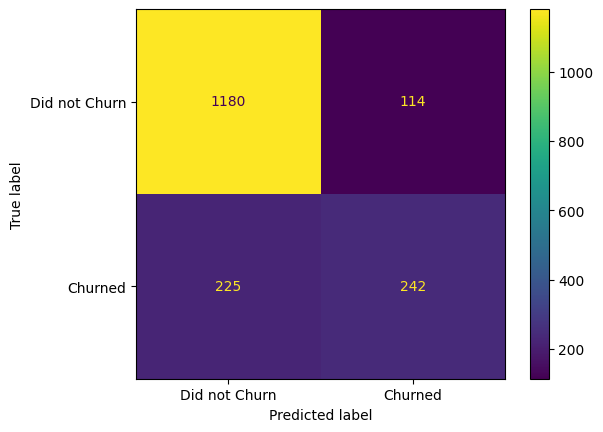

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = clf_xgb.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Did not Churn', 'Churned'])
disp.plot()
plt.show()

Some Analysis:

Of the 467 people who churned, only 242 were classified accurately (242/467=51%).
Of the 1294 people who did not churn, 1180 were predicted accurately (91%).

Therefore, we are predicting far too many people as not churning! We're not able to detect when people are actually churning.

People leaving is very costly, so we want to make sure we can classify people who are actually leaving with a higher degree of accuracy! Specifically, we'd accept most false negatives to achieve this.

The bad prediction likely stemmed from the fact that our dataset is actually imbalanced, so we'd like to handle this. XGBoost has a parameter, scale_pos_weight, that helps with imbalanced data. scale_pos_weight penalizes incorrectly classifying the minority class (e.g. those who did churn), so this should make our model classify these cases more accurately.

# Optimize Parameters using Cross Validation & GridSearch

We use cross-validation and grid search to optimize our hyperparemters.

In [37]:
param_grid = {
  'max_depth': [3,4,5],
  'learning_rate': [0.1, 0.01, 0.05],
  'gamma': [0, 0.25, 1.0],
  'reg_lambda': [0, 1.0, 10.0],
  'scale_pos_weight': [1, 3, 5]
}

# Find best values for first round, and then
# continue to explore in next direction for
# cross-validation
# if middle value, go with it,
# if at an in-between value or at the max, then
# continue to explore in that direction

param_grid = {
    'max_depth': [4],
    'learning_rate': [0.1, 0.5, 1],
    'gamma': [0.25],
    'reg_lambda': [10.0, 20.0, 100.0],
    'scale_pos_weight': [3],
}

'''
For a performance boost, we set subsample=0.9 and colsample_bytree=0.5.
This means that for each new tree, we only sample 90% of the data,
and for each new tree, we only consider 50% of the features, selected
randomly.
'''

optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic', seed=42, subsample=0.9, colsample_bytree=0.5),
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=2,
    n_jobs=10,
    cv=3
)

optimal_params.fit(X_train, y_train)
print(optimal_params.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
{'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 20.0, 'scale_pos_weight': 3}


We found that gamma=0.25, learn_rate=0.1, max_depth=4, reg_lambda=10 yields good results.


# Build the Final Model

In [38]:
clf_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    missing=0,
    seed=42,
    eval_metric='aucpr',
    early_stopping_rounds=10,
    gamma=0.25,
    learning_rate=0.1,
    max_depth=4,
    reg_lambda=10,
    subsample=0.9,
    scale_pos_weight=3,
    colsample_bytree=0.5
  )
clf_xgb.fit(
    X_train,
    y_train,
    verbose=True,
    eval_set=[(X_test, y_test)]
)

[0]	validation_0-aucpr:0.55601
[1]	validation_0-aucpr:0.60406
[2]	validation_0-aucpr:0.61022
[3]	validation_0-aucpr:0.61568
[4]	validation_0-aucpr:0.61774
[5]	validation_0-aucpr:0.61925
[6]	validation_0-aucpr:0.62513
[7]	validation_0-aucpr:0.63171
[8]	validation_0-aucpr:0.63524
[9]	validation_0-aucpr:0.62988
[10]	validation_0-aucpr:0.65176
[11]	validation_0-aucpr:0.65259
[12]	validation_0-aucpr:0.65219
[13]	validation_0-aucpr:0.65424
[14]	validation_0-aucpr:0.64994
[15]	validation_0-aucpr:0.64470
[16]	validation_0-aucpr:0.64622
[17]	validation_0-aucpr:0.64599
[18]	validation_0-aucpr:0.65779
[19]	validation_0-aucpr:0.65790
[20]	validation_0-aucpr:0.65996
[21]	validation_0-aucpr:0.65935
[22]	validation_0-aucpr:0.65953
[23]	validation_0-aucpr:0.66373
[24]	validation_0-aucpr:0.66562
[25]	validation_0-aucpr:0.66347
[26]	validation_0-aucpr:0.66266
[27]	validation_0-aucpr:0.65969
[28]	validation_0-aucpr:0.65739
[29]	validation_0-aucpr:0.65538
[30]	validation_0-aucpr:0.65627
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=0.25, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=0, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

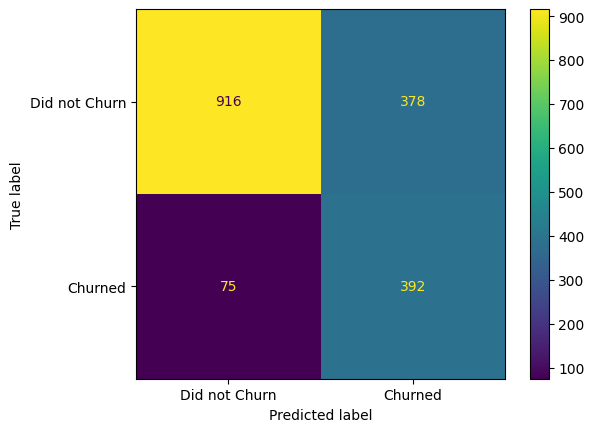

In [39]:
predictions = clf_xgb.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Did not Churn', 'Churned'])
disp.plot()
plt.show()

Let's analyze this result:
Overall Accuracy:
(916+392)/(916+378+75+392) = 74%
Accuracy actually went down, however, we said we wanted to identify people who did churn at a higher percentage. Let's look at our precision & recall on people who did churn.

Precision = (392)/(392+378) = 0.50
Recall = (392)/(392+75) = 0.83

Our recall is fairly high, meaning we did a good job of predicting people who did churn. Note that before, our recall was about 50%. Recall is most likely what we wanted to optimize for, so this is a decent outcome.
